In [7]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error
import pickle
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [8]:
DATA_FOLDER = 'data/'
TRAIN_DATA_FILE = os.path.join(DATA_FOLDER, 'train.feather')
TEST_DATA_FILE = os.path.join(DATA_FOLDER, 'test.feather')
MODEL_FOLDER = 'model/'
os.makedirs(MODEL_FOLDER, exist_ok=True)

TARGET = 'TOTALKWH'

In [9]:
# Load Yeo-Johnson transformer 
with open(os.path.join(DATA_FOLDER, 'yeo_johnson.pkl'), 'rb') as f:
    yeo_Johnson = pickle.load(f)

In [10]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# Load data (assuming TRAIN_DATA_FILE and TEST_DATA_FILE are defined)
train_df = pd.read_feather(TRAIN_DATA_FILE)
test_df = pd.read_feather(TEST_DATA_FILE)

device: cpu


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51322 entries, 1153 to 50613
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TOTALKWH    51322 non-null  float64       
 1   tempAvg     51322 non-null  float64       
 2   winddirAvg  51322 non-null  float64       
 3   population  51322 non-null  float64       
 4   density     51322 non-null  float64       
 5   month       51322 non-null  float64       
 6   month_sin   51322 non-null  float64       
 7   month_cos   51322 non-null  float64       
 8   zipcode     51322 non-null  float64       
 9   latitude    51322 non-null  float64       
 10  longitude   51322 non-null  float64       
 11  YEAR_MONTH  51322 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 5.1 MB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12831 entries, 52310 to 66099
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TOTALKWH    12831 non-null  float64       
 1   tempAvg     12831 non-null  float64       
 2   winddirAvg  12831 non-null  float64       
 3   population  12831 non-null  float64       
 4   density     12831 non-null  float64       
 5   month       12831 non-null  float64       
 6   month_sin   12831 non-null  float64       
 7   month_cos   12831 non-null  float64       
 8   zipcode     12831 non-null  float64       
 9   latitude    12831 non-null  float64       
 10  longitude   12831 non-null  float64       
 11  YEAR_MONTH  12831 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.3 MB


In [13]:
# # Define series to scale and use
series_cols = ['TOTALKWH', 'tempAvg', 'month_sin', 'month_cos', 'population']
# Define sequence length
seq_length = 12

In [14]:
# Function to create sequences with target dates
def create_sequences(df, seq_length, features, target):
    X = []
    y = []
    dates = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i - seq_length:i][features].values)
        y.append(df.iloc[i][target])
        dates.append(df.iloc[i]['YEAR_MONTH'])
    return np.array(X), np.array(y), np.array(dates)

In [15]:
# Create training sequences with dates
X_train, y_train, dates_train = create_sequences(train_df, seq_length, series_cols, TARGET)

# Sort training sequences by target date
sorted_indices = np.argsort(dates_train)
X_train_sorted = X_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        # Dense block with dropout
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_prob)
        
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # take the last timestep
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        out = self.fc3(out)
        return out

In [17]:
FOLD = 8
BATCH_SIZE = 64
NUM_LAYERS = 2
INPUT_SIZE = len(series_cols)
HIDDEN_SIZE = 30
OUTPUT_SIZE = 1
EPOCHS = 100
LEARNING_RATE = 0.001

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=FOLD)

In [18]:
def plot_losses(train_losses, val_losses):
    """
    Plot training and validation loss curves.

    Parameters:
    - train_losses: list of floats, training loss values
    - val_losses: list of floats, validation loss values

    Returns:
    - None

    Sample Usage:
    plot_losses(train_losses, val_losses)
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
def inverse_yeo_johnson(yeo_Johnson, arr):
    """
    Apply inverse Yeo-Johnson transformation to an array using a fitted transformer.

    Parameters:
    - yeo_Johnson: PowerTransformer, fitted Yeo-Johnson transformer
    - arr: array-like, shape (n_samples,), array to inverse transform

    Returns:
    - original_arr: np.ndarray, shape (n_samples,), array after inverse transformation

    Sample Usage:
    original = inverse_yeo_johnson(yeo_transformer, transformed_array)
    """
    arr = np.array(arr).reshape(-1, 1)
    dummy_array = np.zeros((arr.shape[0], yeo_Johnson.n_features_in_))
    dummy_array[:, 0] = arr[:, 0]
    inverse_transformed = yeo_Johnson.inverse_transform(dummy_array)
    original_arr = inverse_transformed[:, 0]
    return original_arr

def initialize_model(input_size, hidden_size, num_layers, output_size, device, learning_rate):
    """
    Initialize the LSTM model, loss function, and optimizer.

    Parameters:
    - input_size: int, number of input features
    - hidden_size: int, number of hidden units in LSTM
    - num_layers: int, number of LSTM layers
    - output_size: int, number of output units
    - device: torch.device, device to run the model on
    - learning_rate: float, learning rate for the optimizer

    Returns:
    - model: LSTM model instance
    - criterion: loss function (MSELoss)
    - optimizer: Adam optimizer instance

    Sample Usage:
    model, criterion, optimizer = initialize_model(10, 64, 2, 1, device, 0.001)
    """
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

def create_dataloaders(X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size, device):
    """
    Create training and validation dataloaders.

    Parameters:
    - X_train_fold, y_train_fold: training features and labels
    - X_val_fold, y_val_fold: validation features and labels
    - batch_size: int, batch size for DataLoader
    - device: torch.device, device to load tensors on

    Returns:
    - train_loader: DataLoader for training set
    - val_loader: DataLoader for validation set

    Sample Usage:
    train_loader, val_loader = create_dataloaders(X_train, y_train, X_val, y_val, 32, device)
    """
    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold).to(device), 
                                  torch.FloatTensor(y_train_fold).to(device))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold).to(device), 
                                torch.FloatTensor(y_val_fold).to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def train_one_epoch(model, train_loader, criterion, optimizer):
    """
    Train the model for one epoch.

    Parameters:
    - model: LSTM model
    - train_loader: DataLoader, training data
    - criterion: loss function
    - optimizer: optimizer
    - device: torch.device

    Returns:
    - avg_train_loss: float, average training loss

    Sample Usage:
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    """
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    return train_loss / len(train_loader.dataset)

def evaluate_one_epoch(model, val_loader, criterion):
    """
    Evaluate the model for one epoch.

    Parameters:
    - model: LSTM model
    - val_loader: DataLoader, validation data
    - criterion: loss function
    - device: torch.device

    Returns:
    - avg_val_loss: float, average validation loss

    Sample Usage:
    val_loss = evaluate_one_epoch(model, val_loader, criterion, device)
    """
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            val_loss += loss.item() * X_batch.size(0)
    return val_loss / len(val_loader.dataset)

def save_best_model(model, val_loss, best_val_loss, MODEL_FOLDER):
    """
    Save the model if validation loss improves.

    Parameters:
    - model: LSTM model
    - val_loss: float, current validation loss
    - best_val_loss: float, best validation loss so far
    - MODEL_FOLDER: str, directory to save model

    Returns:
    - best_val_loss: updated best validation loss
    - early_stop_flag: int, 0 if improved, 1 if no improvement

    Sample Usage:
    best_val_loss, flag = save_best_model(model, val_loss, best_val_loss, "models/")
    """
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_FOLDER, 'best_model_fold.pth'))
        return best_val_loss, 0
    else:
        return best_val_loss, 1

def load_and_evaluate_best_model(model, X_val_fold, y_val_fold, MODEL_FOLDER, device):
    """
    Load the best saved model and evaluate on the validation set.

    Parameters:
    - model: LSTM model
    - X_val_fold, y_val_fold: validation features and labels
    - MODEL_FOLDER: str, directory where the model is saved
    - device: torch.device

    Returns:
    - mape_val: float, mean absolute percentage error on validation
    - r2_val: float, R² score on validation

    Sample Usage:
    mape_val, r2_val = load_and_evaluate_best_model(model, X_val, y_val, "models/", device)
    """
    model.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, 'best_model_fold.pth')))
    print('Best model loaded for evaluation')
    model.eval()
    with torch.no_grad():
        y_pred_val = model(torch.FloatTensor(X_val_fold).to(device)).squeeze().cpu().numpy()

    mape_val = mean_absolute_percentage_error(y_val_fold, y_pred_val)
    r2_val = r2_score(y_val_fold, y_pred_val)
    print(f'Validation MAPE: {mape_val * 100:.2f}%, R²: {r2_val:.4f}')
    return mape_val, r2_val

def train_and_evaluate(MODEL_FOLDER,
                       X_train_fold, y_train_fold, X_val_fold, y_val_fold,
                       input_size, hidden_size, num_layers, output_size,
                       device, patience=5, batch_size=32, epochs=100,
                       learning_rate=0.001):
    """
    Train and evaluate the LSTM model with early stopping.

    Parameters:
    - MODEL_FOLDER: str, directory to save the best model
    - X_train_fold, y_train_fold: training features and labels
    - X_val_fold, y_val_fold: validation features and labels
    - input_size: int, number of input features
    - hidden_size: int, number of hidden units in LSTM
    - num_layers: int, number of LSTM layers
    - output_size: int, number of output units
    - device: torch.device
    - patience: int, early stopping patience
    - batch_size: int, batch size
    - epochs: int, maximum number of epochs
    - learning_rate: float, learning rate

    Returns:
    - mape_val: float, final validation MAPE
    - r2_val: float, final validation R² score

    Sample Usage:
    mape, r2 = train_and_evaluate("models/", X_train, y_train, X_val, y_val, 10, 64, 2, 1, device)
    """
    model, criterion, optimizer = initialize_model(input_size, hidden_size, num_layers, output_size, device, learning_rate)
    train_loader, val_loader = create_dataloaders(X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size, device)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    counter = 0
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss = evaluate_one_epoch(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        best_val_loss, early_stop_flag = save_best_model(model, val_loss, best_val_loss, MODEL_FOLDER)
        counter += early_stop_flag
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    plot_losses(train_losses, val_losses)
    mape_val, r2_val = load_and_evaluate_best_model(model, X_val_fold, y_val_fold, MODEL_FOLDER, device)

    return mape_val, r2_val

In [19]:
# # Function to train and evaluate a model for one fold
# def train_and_evaluate(MODEL_FOLDER, 
#                        X_train_fold, y_train_fold, X_val_fold, y_val_fold, 
#                        input_size, hidden_size, num_layers, output_size, 
#                        device, patience=5, batch_size=BATCH_SIZE, epochs=EPOCHS, 
#                        learning_rate=LEARNING_RATE):
#     model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     
#     train_dataset = TensorDataset(torch.FloatTensor(X_train_fold).to(device), torch.FloatTensor(y_train_fold).to(device))
#     val_dataset = TensorDataset(torch.FloatTensor(X_val_fold).to(device), torch.FloatTensor(y_val_fold).to(device))
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#     
#     best_val_loss = float('inf')
#     train_losses, val_losses = [], []
#     counter = 0  # For early stopping
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             output = model(X_batch)
#             loss = criterion(output.squeeze(), y_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * X_batch.size(0)
#         train_loss /= len(train_dataset)
#         train_losses.append(train_loss)
#         
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 output = model(X_batch)
#                 loss = criterion(output.squeeze(), y_batch)
#                 val_loss += loss.item() * X_batch.size(0)
#         val_loss /= len(val_dataset)
#         val_losses.append(val_loss)
#         print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
#         
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 
#                        os.path.join(MODEL_FOLDER, 'best_model_fold.pth'))
#             counter = 0
#         else:
#             counter += 1
#             if counter >= patience:
#                 print(f'Early stopping at epoch {epoch}')
#                 break
#     
#     # Plot training and validation loss
#     plot_losses(train_losses, val_losses)
#     
#     # Load best model for this fold
#     model.load_state_dict(torch.load(
#         os.path.join(MODEL_FOLDER, 'best_model_fold.pth')))
#     print('Best model loaded for evaluation')
#     
#     model.eval()
#     with torch.no_grad():
#         y_pred_val = model(torch.FloatTensor(X_val_fold).to(device)).squeeze().cpu().numpy()
#     # y_val_original = yeo_Johnson.inverse_transform(y_val_fold.reshape(-1, 1)).flatten()
#     # y_pred_original = yeo_Johnson.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
#     # y_val_original = inverse_yeo_johnson(yeo_Johnson, y_val_fold)
#     # y_pred_original = inverse_yeo_johnson(yeo_Johnson, y_pred_val)
#     # mape_val, r2_val = calculate_metrics(y_val_original, y_pred_original)
#     mape_val = mean_absolute_percentage_error(y_val_fold, y_pred_val)
#     r2_val = r2_score(y_val_fold, y_pred_val)
#     
#     print(f'Validation MAPE: {mape_val * 100:.2f}%, R²: {r2_val:.4f}')
#     return mape_val, r2_val

Training on fold 1 / 8:
Epoch 1/100, Train Loss: 0.7252, Val Loss: 0.7376
Epoch 11/100, Train Loss: 0.6048, Val Loss: 0.6714
Early stopping at epoch 12


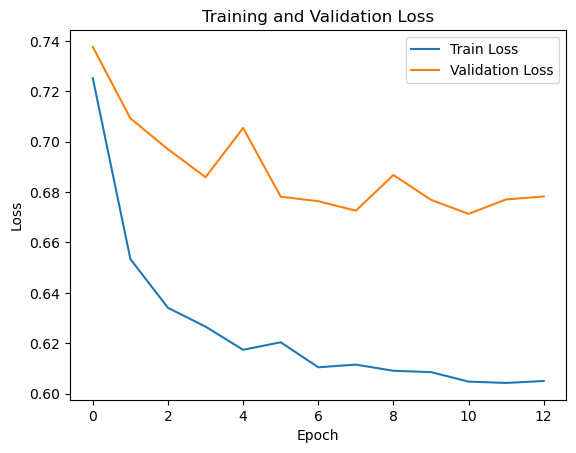

Best model loaded for evaluation
Validation MAPE: 251.53%, R²: 0.3027
Training on fold 2 / 8:
Epoch 1/100, Train Loss: 0.7343, Val Loss: 0.6615
Epoch 11/100, Train Loss: 0.6268, Val Loss: 0.6283
Early stopping at epoch 10


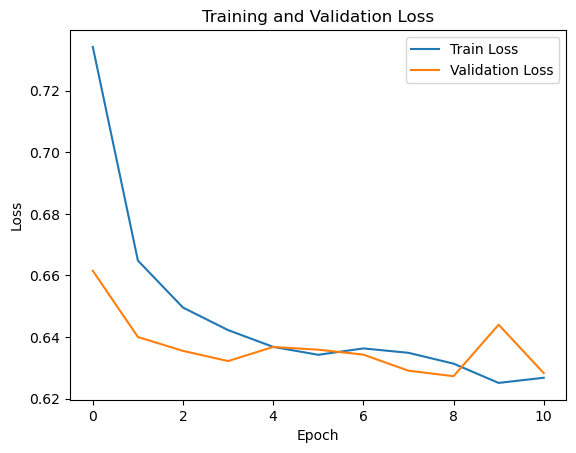

Best model loaded for evaluation
Validation MAPE: 374.59%, R²: 0.3198
Training on fold 3 / 8:
Epoch 1/100, Train Loss: 0.7154, Val Loss: 0.7484
Early stopping at epoch 8


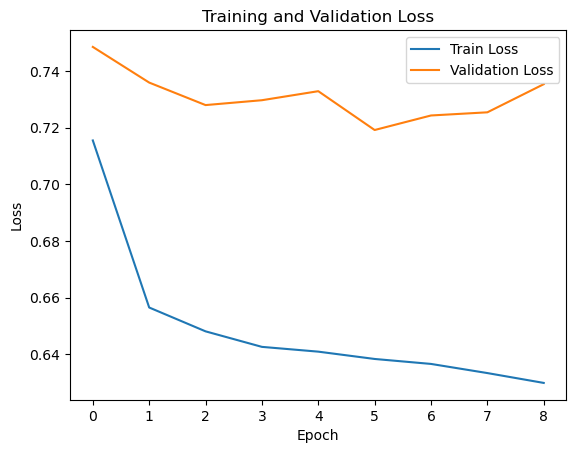

Best model loaded for evaluation
Validation MAPE: 233.11%, R²: 0.3025
Training on fold 4 / 8:
Epoch 1/100, Train Loss: 0.7305, Val Loss: 0.7187
Epoch 11/100, Train Loss: 0.6437, Val Loss: 0.6761
Epoch 21/100, Train Loss: 0.5823, Val Loss: 0.6121
Epoch 31/100, Train Loss: 0.5024, Val Loss: 0.5337
Epoch 41/100, Train Loss: 0.4525, Val Loss: 0.4993
Early stopping at epoch 43


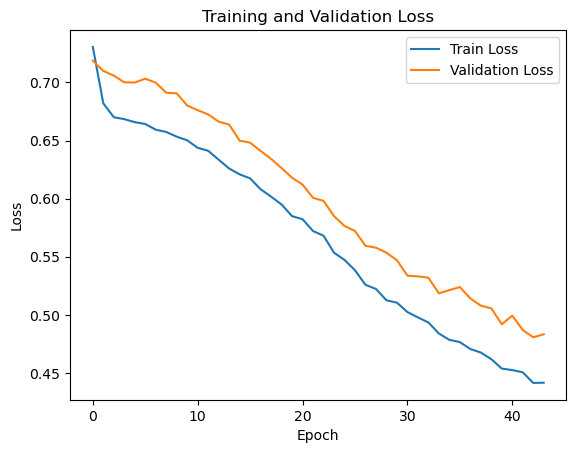

Best model loaded for evaluation
Validation MAPE: 308.86%, R²: 0.5197
Training on fold 5 / 8:
Epoch 1/100, Train Loss: 0.7319, Val Loss: 0.7361
Early stopping at epoch 8


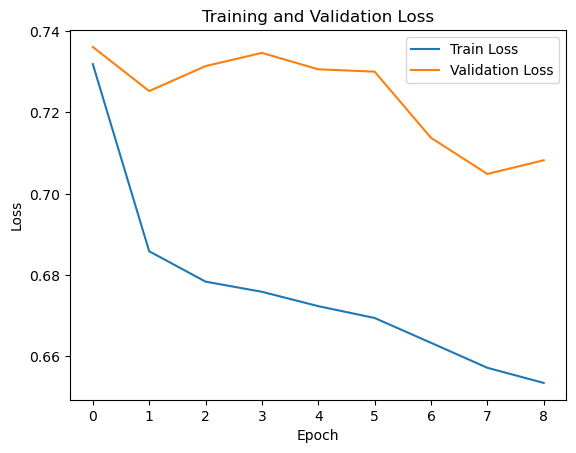

Best model loaded for evaluation
Validation MAPE: 170.38%, R²: 0.3233
Training on fold 6 / 8:
Epoch 1/100, Train Loss: 0.7360, Val Loss: 0.7386
Epoch 11/100, Train Loss: 0.6254, Val Loss: 0.6520
Epoch 21/100, Train Loss: 0.5147, Val Loss: 0.5092
Epoch 31/100, Train Loss: 0.4448, Val Loss: 0.4279
Early stopping at epoch 32


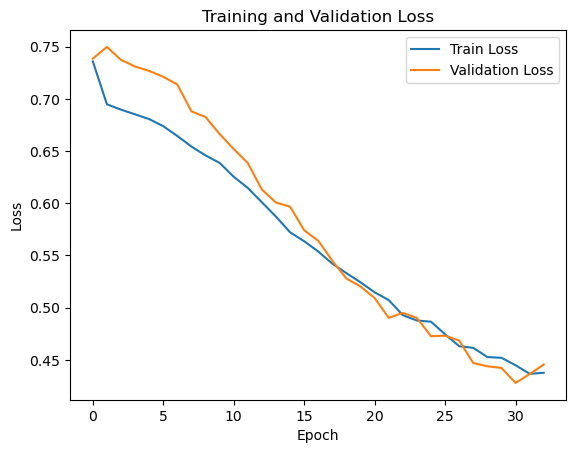

Best model loaded for evaluation
Validation MAPE: 217.24%, R²: 0.5995
Training on fold 7 / 8:
Epoch 1/100, Train Loss: 0.7440, Val Loss: 0.7183
Epoch 11/100, Train Loss: 0.6300, Val Loss: 0.6175
Epoch 21/100, Train Loss: 0.5156, Val Loss: 0.4782
Epoch 31/100, Train Loss: 0.4457, Val Loss: 0.4165
Early stopping at epoch 35


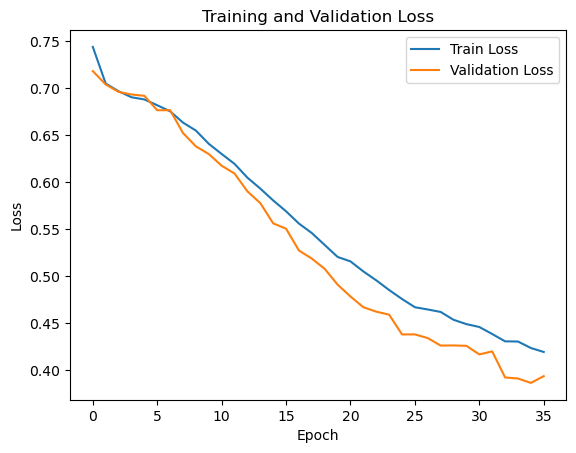

Best model loaded for evaluation
Validation MAPE: 252.72%, R²: 0.6147
Training on fold 8 / 8:
Epoch 1/100, Train Loss: 0.7458, Val Loss: 0.7718
Epoch 11/100, Train Loss: 0.6055, Val Loss: 0.6083
Epoch 21/100, Train Loss: 0.4839, Val Loss: 0.4497
Epoch 31/100, Train Loss: 0.4194, Val Loss: 0.3935
Early stopping at epoch 34


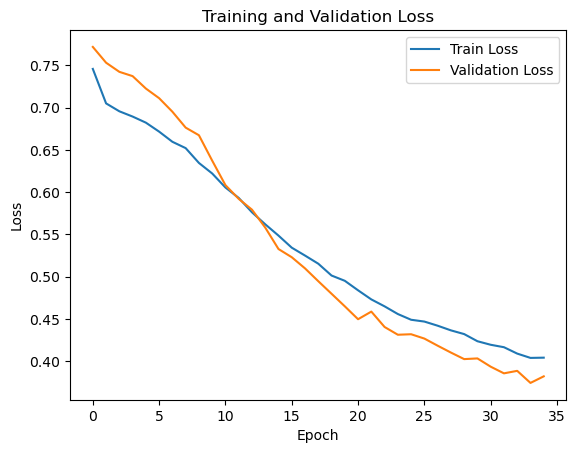

Best model loaded for evaluation
Validation MAPE: 186.13%, R²: 0.6517
Average MAPE across folds: 249.32%
Average R² across folds: 0.4542


In [20]:
# Perform TSCV
mape_scores = []
r2_scores = []
for train_idx, val_idx in tscv.split(X_train_sorted):
    print(f'Training on fold {len(mape_scores) + 1} / {FOLD}:')
    X_train_fold = X_train_sorted[train_idx]
    y_train_fold = y_train_sorted[train_idx]
    X_val_fold = X_train_sorted[val_idx]
    y_val_fold = y_train_sorted[val_idx]
    
    mape_val, r2_val= train_and_evaluate(
        MODEL_FOLDER, 
        X_train_fold, y_train_fold, X_val_fold, y_val_fold, 
        input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, 
        num_layers=NUM_LAYERS, output_size=OUTPUT_SIZE, device=device)
    mape_scores.append(mape_val)
    r2_scores.append(r2_val)

print(f'Average MAPE across folds: {np.mean(mape_scores) * 100:.2f}%')
print(f'Average R² across folds: {np.mean(r2_scores):.4f}')

In [27]:
# Calculation standard deviation of MAPE and R² scores
mape_std = np.std(mape_scores)
r2_std = np.std(r2_scores)
print(f'Standard Deviation of MAPE across folds: {mape_std * 100:.2f}%')
print(f'Standard Deviation of R² across folds: {r2_std:.4f}')

Standard Deviation of MAPE across folds: 62.02%
Standard Deviation of R² across folds: 0.1463


In [21]:
# Refit final model on entire training set with early stopping
train_idx, val_idx = list(tscv.split(X_train_sorted))[-1]
X_train_final = X_train_sorted[train_idx]
y_train_final = y_train_sorted[train_idx]
X_val_final = X_train_sorted[val_idx]
y_val_final = y_train_sorted[val_idx]

In [22]:
# Train final model
model = LSTMModel(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE,
                  num_layers=NUM_LAYERS, output_size=OUTPUT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataset = TensorDataset(torch.FloatTensor(X_train_final).to(device), torch.FloatTensor(y_train_final).to(device))
val_dataset = TensorDataset(torch.FloatTensor(X_val_final).to(device), torch.FloatTensor(y_val_final).to(device))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Epoch 1/100, Train Loss: 0.7559, Val Loss: 0.7632
Epoch 11/100, Train Loss: 0.6310, Val Loss: 0.6568
Epoch 21/100, Train Loss: 0.5143, Val Loss: 0.5146
Epoch 31/100, Train Loss: 0.4464, Val Loss: 0.4254
Epoch 41/100, Train Loss: 0.4091, Val Loss: 0.3890
Epoch 51/100, Train Loss: 0.3809, Val Loss: 0.3655
Epoch 61/100, Train Loss: 0.3663, Val Loss: 0.3411
Epoch 71/100, Train Loss: 0.3500, Val Loss: 0.3384
Epoch 81/100, Train Loss: 0.3375, Val Loss: 0.3155
Epoch 91/100, Train Loss: 0.3294, Val Loss: 0.3142
Early stopping at epoch 94


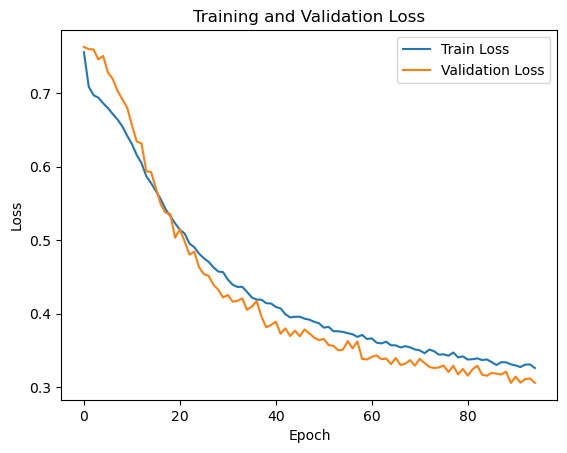

In [23]:
best_val_loss = float('inf')
patience = 5
counter = 0
train_losses, val_losses = [], []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_FOLDER, 'best_model_final.pth'))
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
            
# Plot training and validation loss
plot_losses(train_losses, val_losses)

In [24]:
# Load best final model
model.load_state_dict(torch.load(os.path.join(MODEL_FOLDER, 'best_model_final.pth')))
model.eval()

# Create test sequences without considering zipcode
if len(test_df) >= seq_length:
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    X_all, y_all, _ = create_sequences(combined_df, seq_length, series_cols, TARGET)
    start_test = max(0, len(train_df) - seq_length)
    end_test = len(combined_df) - seq_length
    X_test = X_all[start_test:end_test]
    y_test = y_all[start_test:end_test]
else:
    X_test = np.array([])
    y_test = np.array([])

In [26]:
# Predict on test data
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.FloatTensor(X_test).to(device)).squeeze().cpu().numpy()
y_test_scaled = y_test

# Inverse transform predictions and actual values
y_test_original = inverse_yeo_johnson(yeo_Johnson, y_test_scaled)
y_pred_original = inverse_yeo_johnson(yeo_Johnson, y_pred_scaled)

# Calculate evaluation metrics on test set
mape_test = mean_absolute_percentage_error(y_test_original, y_pred_original)
r2_test = r2_score(y_test_original, y_pred_original)
mae_test = mean_absolute_error(y_test_original, y_pred_original)

print(f'Test MAPE: {mape_test * 100:.2f}%')
print(f'Test R²: {r2_test:.4f}')
print(f'Test MAE: {mae_test:.4f}')

Test MAPE: 144.13%
Test R²: 0.1954
Test MAE: 3606711.3222


D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
